# UNET 프로토타입 제작

# class와 함수 정의

### UNET 모델링 class

In [1]:
import matplotlib.pyplot as plt

from keras import models, backend
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, BatchNormalization, Concatenate, Activation

In [2]:
class UNET(models.Model):
    def __init__(self, org_shape, n_ch):
        ic = 3 if backend.image_data_format() == 'channels_last' else 1

        # 수축
        def conv(x, n_f, mp_flag=True):
            x = MaxPooling2D((2, 2), padding='same')(x) if mp_flag else x
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Dropout(0.05)(x)
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x
        
        # 확장
        def deconv_unet(x, e, n_f):
            x = UpSampling2D((2, 2))(x)
            x = Concatenate(axis=ic)([x, e])
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x

        # Input
        original = Input(shape=org_shape)

        # Encoding
        c1 = conv(original, 16, mp_flag=False)
        c2 = conv(c1, 32)

        # Encoder
        encoded = conv(c2, 64)

        # Decoding
        x = deconv_unet(encoded, c2, 32)
        x = deconv_unet(x, c1, 16)

        decoded = Conv2D(n_ch, (3, 3), activation='sigmoid', padding='same')(x)
        #decoded = Conv2D(n_ch, (3, 3), padding='same')(x)

        super().__init__(original, decoded)
        self.compile(optimizer='adadelta', metrics=['acc'], loss='mse')

### 데이터 생성 class

In [3]:
from keras import datasets, utils
import tensorflow as tf
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
class DATA():
    def __init__(self):
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

        if backend.image_data_format() == 'channels_first':
            n_ch, img_rows, img_cols = x_train.shape[1:]
            input_shape = (1, img_rows, img_cols)
        else:
            img_rows, img_cols, n_ch = x_train.shape[1:]
            input_shape = (img_rows, img_cols, 1)

        x_train = x_train.astype('float32') / 255.0
        x_test = x_test.astype('float32') / 255.0
    
        def RGB2Gray(img, fmt):
            if fmt == 'channels_first':
                R = img[:, 0:1]
                G = img[:, 1:2]
                B = img[:, 2:3]
            else:
                R = img[..., 0:1]
                G = img[..., 1:2]
                B = img[..., 2:3]
            return 0.299 * R + 0.587 * G + 0.114 * B
    
        x_train_in = RGB2Gray(x_train, backend.image_data_format())
        x_test_in = RGB2Gray(x_test, backend.image_data_format())

        self.input_shape = input_shape
        self.x_train_in, self.x_train_out = x_train_in, x_train
        self.x_test_in, self.x_test_out = x_test_in, x_test
        self.n_ch = n_ch

### UNET 학습 과정 그래프 출력 함수

In [5]:
import matplotlib.pyplot as plt

In [6]:
def plot_acc(history, title=None):
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Accracy')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_loss(history, title=None):
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_history(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plot_acc(history)
    plt.subplot(1, 2, 2)
    plot_loss(history)

### UNET 결과 이미지 출력 함수

In [7]:
import numpy as np
from sklearn.preprocessing import minmax_scale

In [8]:
def show_images(data, unet):
    x_test_in = data.x_test_in
    x_test_out = data.x_test_out
    decoded_imgs_org = unet.predict(x_test_in)
    decoded_imgs = decoded_imgs_org

    if backend.image_data_format() == 'channels_first':
        print(x_test_out.shape)
        x_test_out = x_test_out.swapaxes(1, 3).swapaxes(1, 2)
        print(x_test_out.shape)
        decoded_imgs = decoded_imgs.swapaxes(1, 3).swapaxes(1, 2)
        
        x_test_in = x_test_in[:, 0, ...]
        
    else:
        x_test_in = x_test_in[..., 0]
        

    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):

        ax = plt.subplot(3, n, i + 1)
        if x_test_in.ndim < 4:
            plt.imshow(x_test_in[i], cmap='gray')
        else:
            plt.imshow(x_test_in[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(x_test_out[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

# UNET을 이용한 흑백 이미지 컬러 복원 실행

### main() 함수로 한번에 진행

In [9]:
# import keras

In [10]:
# def main(epochs=50, batch_size=64):
#     data = DATA()
#     print(data.input_shape, data.x_train_in.shape)

#     unet = UNET(data.input_shape, data.n_ch)

#     earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                                   mode='min', 
#                                                   verbose=1, 
#                                                   patience=10)

#     history = unet.fit(data.x_train_in, data.x_train_out,
#                        epochs=epochs,
#                        batch_size=batch_size,
#                        shuffle=True,
#                        validation_split=0.2,
#                        callbacks=[earlystopping])

#     plot_history(history)
#     show_images(data, unet)

In [11]:
# main()

### 데이터 불러오기

In [12]:
data = DATA()
print(data.input_shape, data.x_train_in.shape)

(32, 32, 1) (50000, 32, 32, 1)


In [18]:
data.x_train_in[0][0][0]

array([0.24006666], dtype=float32)

In [22]:
data.x_train_out[0][0][0]

array([0.23137255, 0.24313726, 0.24705882], dtype=float32)

In [23]:
data.x_train_out

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

### UNET 컴파일

In [13]:
unet = UNET(data.input_shape, data.n_ch)
unet.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
_______________________________________________________________________________________________

### 하이퍼파라미터 설정

In [14]:
import keras

In [15]:
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [16]:
epochs=50
batch_size=64

### 모델 학습

In [17]:
history = unet.fit(data.x_train_in, data.x_train_out,
                   epochs=epochs,
                   batch_size=batch_size,
                   shuffle=True,
                   validation_split=0.2,
                   callbacks=[earlystopping])

Epoch 1/50
625/625 [==============================] - 50s 29ms/step - loss: 0.0672 - acc: 0.3309 - val_loss: 0.0452 - val_acc: 0.3354
Epoch 2/50
625/625 [==============================] - 16s 25ms/step - loss: 0.0436 - acc: 0.3350 - val_loss: 0.0361 - val_acc: 0.3405
Epoch 3/50
625/625 [==============================] - 17s 27ms/step - loss: 0.0362 - acc: 0.3399 - val_loss: 0.0322 - val_acc: 0.3432
Epoch 4/50
625/625 [==============================] - 18s 29ms/step - loss: 0.0327 - acc: 0.3425 - val_loss: 0.0301 - val_acc: 0.3445
Epoch 5/50
625/625 [==============================] - 16s 26ms/step - loss: 0.0305 - acc: 0.3444 - val_loss: 0.0286 - val_acc: 0.3449
Epoch 6/50
625/625 [==============================] - 16s 25ms/step - loss: 0.0291 - acc: 0.3453 - val_loss: 0.0273 - val_acc: 0.3456
Epoch 7/50
625/625 [==============================] - 16s 26ms/step - loss: 0.0277 - acc: 0.3466 - val_loss: 0.0262 - val_acc: 0.3460
Epoch 8/50
625/625 [==============================] - 16s 25ms

### 결과 확인

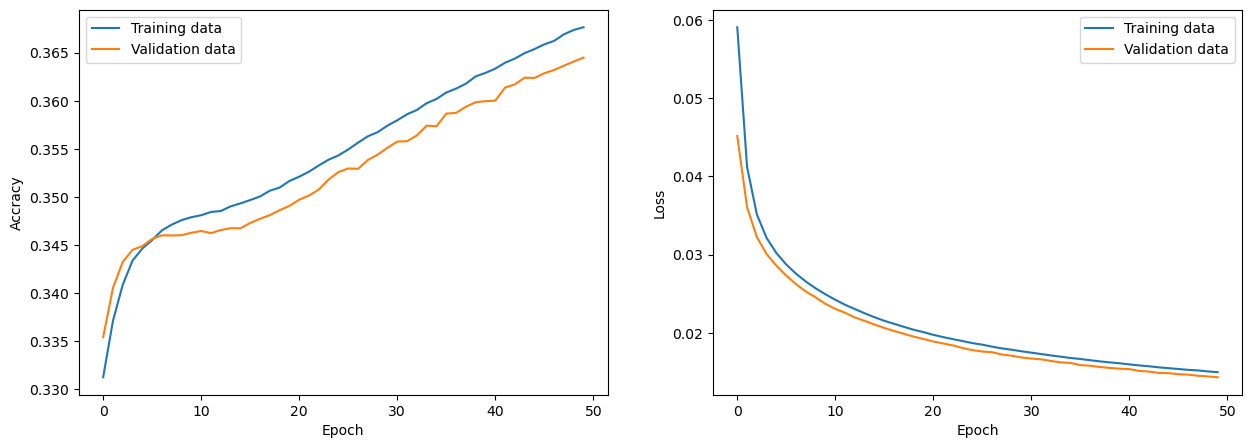

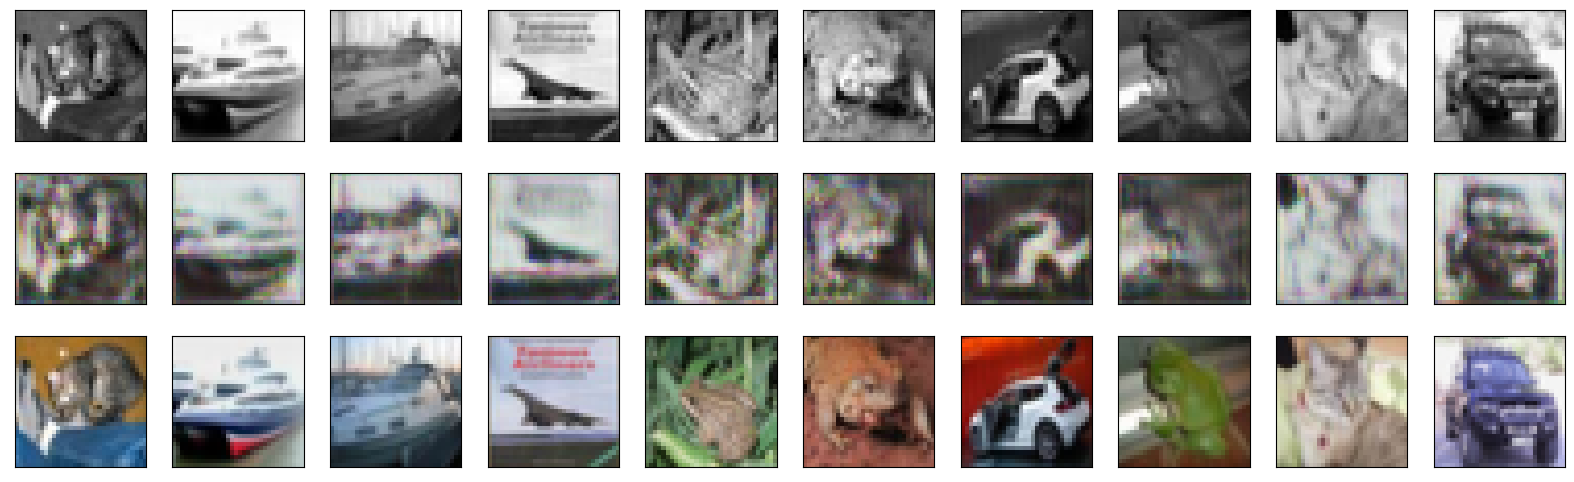

In [22]:
plot_history(history)
show_images(data, unet)